In [1]:
import bec4fit
import bec4lib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
import importlib
importlib.reload(bec4fit)

<module 'bec4fit' from 'c:\\Users\\lazarus\\SPDF decay\\bec4py\\bec4fit.py'>

In [17]:
ids = np.arange(390852,390957+1)
imgs = bec4lib.queryImages(ids)
camInfo = bec4lib.queryImageSize(ids)
imgs = np.vstack(imgs)

In [82]:
dat = bec4lib.BEC4image(imgs,camInfo)
#dat.dispersiveImage(pwaLoc = [2,3,4],knifeEdge=10,doPCA=True);
dat.absorptiveKinetic(knifeEdge=25,bottomEdge=30,doPCA=False)
scan_var = bec4lib.queryVariable(ids,'Generic_Hold_Time')
doublonMode = bec4lib.queryVariable(ids,varname='doublonMode')

### PCA by unique scan variable groups

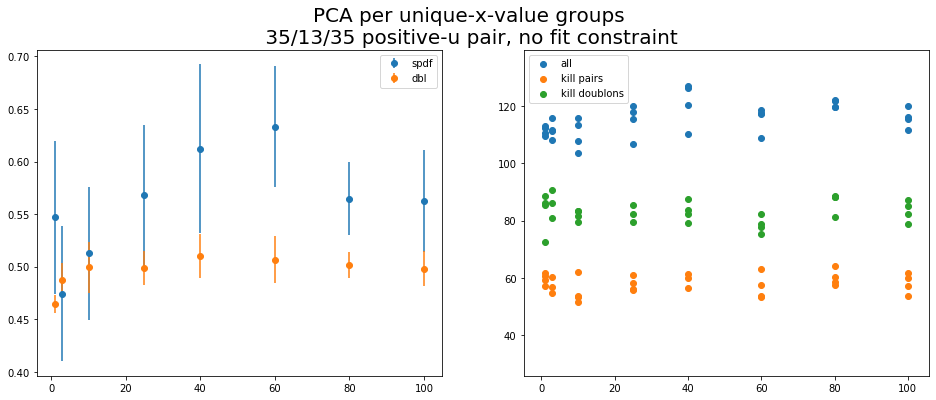

In [134]:
xvar_unique, key, counts = np.unique(scan_var,return_inverse=True,return_counts=True)

pwa = dat.pwa
pwoa = dat.pwoa
dark = dat.dark
temp = []
total = 0

for cts in counts:
    pwa_select = pwa[total:total+cts].reshape(cts,-1)
    pwoa_select = pwoa[total:total+cts].reshape(cts,-1)
    dark_select = dark[total:total+cts].reshape(cts,-1)

    total += cts
    pwoaTrue = pwoa_select-dark_select
    pwoaTrueMean = np.mean(pwoaTrue,axis=0)
    pwaTrue = pwa_select-dark_select

    _,_,VH = np.linalg.svd(pwoaTrue-pwoaTrueMean,full_matrices=False)
    estPWOA = ((pwaTrue-pwoaTrueMean)@(VH.T))@VH + pwoaTrueMean
    temp.append(-np.log(np.maximum(np.abs(pwaTrue/estPWOA),0.002)))

absImg_pca = np.vstack(temp).reshape(dat.shotsN,dat.colN,-1)

ncount = np.zeros((dat.shotsN))
for i,image in enumerate(absImg_pca):
    fparsx,fparsy,xcut,ycut = bec4fit.absImgNcount(image)
    nx = 2*np.sqrt(np.pi)*fparsx[0]*np.abs(fparsx[2])
    ny = 2*np.sqrt(np.pi)*fparsy[0]*np.abs(fparsy[2])
    ncount[i] = np.sqrt(nx*ny)

dblfrac,spdf,dblerr,spdferr = bec4lib.doublonAnalysis(ncount,doublonMode,scan_var)

fig = plt.figure(figsize=(16,6))
fig.add_subplot(1,2,1)
plt.errorbar(xvar_unique,spdf,yerr=spdferr,fmt="o",label='spdf')
plt.errorbar(xvar_unique,dblfrac,yerr=dblerr,fmt="o",label='dbl')
plt.legend()

fig.add_subplot(1,2,2)
plt.scatter(scan_var[doublonMode==1],ncount[doublonMode==1],label="all")
plt.scatter(scan_var[doublonMode==2],ncount[doublonMode==2],label="kill pairs")
plt.scatter(scan_var[doublonMode==3],ncount[doublonMode==3],label="kill doublons")
plt.ylim([np.min(ncount)/2,np.max(ncount)*1.1])
plt.legend()
fig.suptitle("PCA per unique-x-value groups\n 35/13/35 positive-u pair, no fit constraint",fontsize=20)
plt.savefig("back_to_abs_img.png")

### Add fit constraints based on mean images

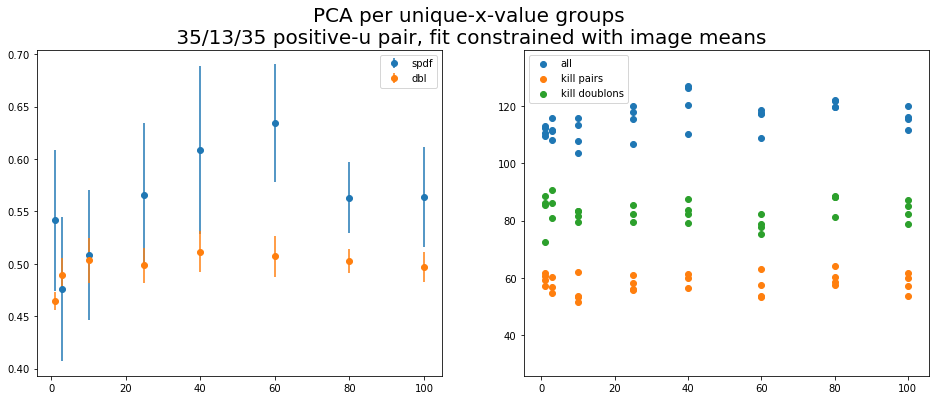

In [147]:
constraints = dict()
mean_images = dict()

for xval in xvar_unique:
    for i in range(3):
        test_mean_image = np.mean(absImg_pca[np.logical_and(doublonMode==i+1,scan_var == xval)],axis=0)
        fparsx,fparsy,xcut,ycut = bec4fit.absImgNcount(test_mean_image)
        constraints[(i+1,xval)] = (fparsx,fparsy)
        mean_images[(i+1,xval)] = (xcut,ycut)

ncount_c = np.zeros((dat.shotsN))
for i,image in enumerate(absImg_pca):
    dm = doublonMode[i]
    xval = scan_var[i]
    fparsx,fparsy,_,_ = bec4fit.absImgNcount(image,isConstrained=True,p0c=constraints[dm,xval])
    nx = 2*np.sqrt(np.pi)*fparsx[0]*np.abs(fparsx[2])
    ny = 2*np.sqrt(np.pi)*fparsy[0]*np.abs(fparsy[2])
    ncount_c[i] = np.sqrt(nx*ny)

dblfrac,spdf,dblerr,spdferr = bec4lib.doublonAnalysis(ncount_c,doublonMode,scan_var)

fig = plt.figure(figsize=(16,6))
fig.add_subplot(1,2,1)
plt.errorbar(xvar_unique,spdf,yerr=spdferr,fmt="o",label='spdf')
plt.errorbar(xvar_unique,dblfrac,yerr=dblerr,fmt="o",label='dbl')
plt.legend()

fig.add_subplot(1,2,2)
plt.scatter(scan_var[doublonMode==1],ncount[doublonMode==1],label="all")
plt.scatter(scan_var[doublonMode==2],ncount[doublonMode==2],label="kill pairs")
plt.scatter(scan_var[doublonMode==3],ncount[doublonMode==3],label="kill doublons")
plt.ylim([np.min(ncount)/2,np.max(ncount)*1.1])
plt.legend()
fig.suptitle("PCA per unique-x-value groups\n 35/13/35 positive-u pair, fit constrained with image means",fontsize=20)
plt.savefig("back_to_abs_img_2.png")

In [150]:
np.mean([1,2,3,4])

2.5

# Previous analysis

In [62]:
ncount = np.zeros((dat.shotsN))
doublon_mode = []
scan_var = []
for i in range(0,dat.shotsN):
    _,flag = bec4fit.findCloud(dat.absImg[i,5:-5,:])
    if flag == 0:
        #param,_ = bec4fit.fit_2DGaussian(dat.absImg[i,10:90,:])
        #ncount[i] = 2*np.pi*np.prod(param[2:5])
        ncount[i] = bec4fit.absImgNcount(dat.absImg[i,5:-5,:])
        doublon_mode.append(varlist1[i])
        scan_var.append(varlist2[i])
    else:
        print(f"empty shot detected, index {i}")
doublon_mode = np.array(doublon_mode)
scan_var = np.array(scan_var)

AttributeError: 'BEC4image' object has no attribute 'absImg'

In [63]:
_, doublon_mode = np.unique(doublon_mode,return_inverse=True)
x_unique,_ = np.unique(varlist2, return_inverse=True)
all_atoms = []
kill_dbl = []
kill_pair = []
for x_val in x_unique:
    all_atoms.append(ncount[np.logical_and(doublon_mode==0,varlist2 == x_val)])
    kill_dbl.append(ncount[np.logical_and(doublon_mode==1,varlist2 == x_val)])
    kill_pair.append(ncount[np.logical_and(doublon_mode==2,varlist2 == x_val)])
    
dblFrac,spdf,dblerr,spdferr = bec4lib.doublonAnalysis(ncount,varlist1,varlist2)


NameError: name 'varlist2' is not defined

TypeError: only integer scalar arrays can be converted to a scalar index

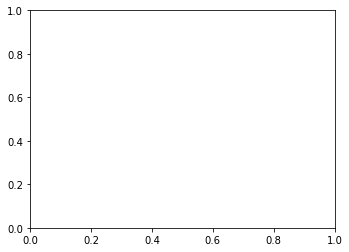

In [64]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(1,2,1)
plt.scatter(np.sort(scan_var[doublon_mode==0]),np.hstack(all_atoms),label='all')
plt.scatter(np.sort(scan_var[doublon_mode==1]),np.hstack(kill_dbl),label='dbl')
plt.scatter(np.sort(scan_var[doublon_mode==2]),np.hstack(kill_pair),label ='pair')
plt.legend()
plt.xlabel("dimple_Top (V)")

fig.add_subplot(1,2,2)
plt.errorbar(np.unique(varlist2),spdf,spdferr,fmt="o",label='SPDF')
plt.errorbar(np.unique(varlist2),dblFrac,dblerr,fmt="o",label='dbl frac')
plt.xlabel("dimple_Top(V)")
plt.legend()

plt.suptitle("side absorption imaging / check doublon fraction")
plt.savefig("oct_26_2020_check_dbl_frac.png")

### Dispersive image analysis

In [102]:
dat = bec4lib.BEC4image(imgs,camInfo)
dat.dispersiveImage(pwaLoc = [2,3,4],knifeEdge=35,doPCA=True);
varlist = bec4lib.queryVariable(ids,'Generic_Hold_Time')

In [103]:
ncount = np.zeros((dat.shotsN,3))
#doublon_mode = []
scan_var = []
for i in range(0,dat.shotsN):
    for j in range(0,3):
        popt,cutout = bec4fit.fit_2DGaussian(dat.pciImg[i,j])
        ncount[i,j] = 2*np.pi*np.prod(popt[2:5])
    scan_var.append(varlist[i])
scan_var = np.array(scan_var)

In [104]:
spdf_dat = bec4lib.spdf_jackknife(scan_var,ncount,flag=0)

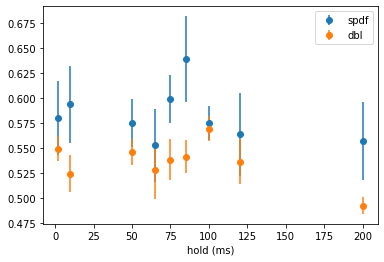

In [105]:
plt.errorbar(np.unique(scan_var),spdf_dat[:,1,0],yerr = spdf_dat[:,1,1],fmt='o',label='spdf')
plt.errorbar(np.unique(scan_var),spdf_dat[:,0,0],yerr = spdf_dat[:,0,1],fmt='o',label="dbl")
plt.xlabel("hold (ms)")
plt.legend()
#plt.title("35/9/35 |1,-1> + |1,1> pair\n PCA applied")
plt.savefig("preliminary_positive-u.png")

In [106]:
dbls = (dat.pwa[:,0,:,:]-dat.pwa[:,2,:,:])/((dat.pwoa[:,0,:,:]+dat.pwoa[:,2,:,:])/2 - dat.dark[:,0,:,:])
alls = (dat.pwa[:,0]-dat.pwoa[:,0])/(dat.pwoa[:,0]-dat.dark[:,0])
killpairs = (dat.pwa[:,1]-dat.pwoa[:,1])/(dat.pwoa[:,1]-dat.dark[:,1])

In [107]:
ncount_dbl = np.zeros((dat.shotsN,1))
ncount_all = np.zeros((dat.shotsN,1))
ncount_killpairs = np.zeros((dat.shotsN,1))
for i in range(dat.shotsN):
    param2, _ = bec4fit.fit_2DGaussian(dbls[i])
    ncount_dbl[i] = 2*np.pi*np.prod(param2[2:5])
    param1, _ = bec4fit.fit_2DGaussian(alls[i])
    param3, _ = bec4fit.fit_2DGaussian(killpairs[i])
    ncount_killpairs[i] = 2*np.pi*np.prod(param3[2:5])
    ncount_all[i] = 2*np.pi*np.prod(param1[2:5])

ncount_array = np.hstack([ncount_all,ncount_killpairs,ncount_dbl])


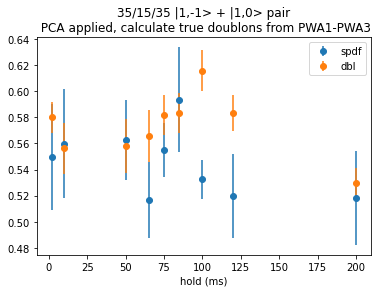

In [108]:
spdf_dat = bec4lib.spdf_jackknife(scan_var,ncount_array,flag=1)
plt.errorbar(np.unique(scan_var),spdf_dat[:,1,0],yerr = spdf_dat[:,1,1],fmt='o',label='spdf')
plt.errorbar(np.unique(scan_var),spdf_dat[:,0,0],yerr = spdf_dat[:,0,1],fmt='o',label="dbl")
plt.xlabel("hold (ms)")
plt.legend()
plt.title("35/15/35 |1,-1> + |1,0> pair\n PCA applied, calculate true doublons from PWA1-PWA3")
plt.savefig("preliminary_positive-u_v2.png")

In [122]:
dbls = (dat.pwa[:,0,:,:]-dat.pwa[:,2,:,:])/((dat.pwoa[:,0,:,:]+dat.pwoa[:,2,:,:])/2 - dat.dark[:,0,:,:])
alls = (dat.pwa[:,0]-dat.pwoa[:,0])/(dat.pwoa[:,0]-dat.dark[:,0])
pairs = (dat.pwa[:,0,:,:]-dat.pwa[:,1,:,:])/((dat.pwoa[:,0,:,:]+dat.pwoa[:,1,:,:])/2 - dat.dark[:,0,:,:])

xmin, xmax = 20, 50
ymin, ymax = 20, 50

alls = alls[:, ymin:ymax, xmin:xmax]
dbls = dbls[:, ymin:ymax, xmin:xmax]
pairs = pairs[:, ymin:ymax, xmin:xmax]

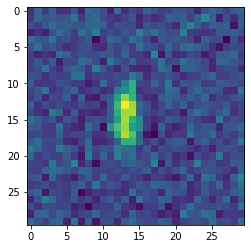

In [123]:
plt.imshow(alls[0])

In [125]:
ncount_dbl = np.zeros((dat.shotsN,1))
ncount_all = np.zeros((dat.shotsN,1))
ncount_pairs = np.zeros((dat.shotsN,1))
for i in range(dat.shotsN):
    param2, _ = bec4fit.fit_2DGaussian(dbls[i])
    ncount_dbl[i] = 2*np.pi*np.prod(param2[2:5])
    param1, _ = bec4fit.fit_2DGaussian(alls[i])
    param3, _ = bec4fit.fit_2DGaussian(pairs[i])
    ncount_all[i] = 2*np.pi*np.prod(param1[2:5])
    ncount_pairs[i] = 2*np.pi*np.prod(param3[2:5])

ncount_array = np.hstack([ncount_all,ncount_pairs,ncount_dbl])

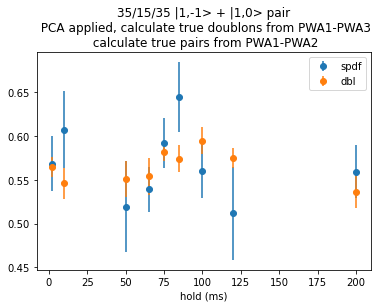

In [126]:
spdf_dat = bec4lib.spdf_jackknife(scan_var,ncount_array,flag=2)
plt.errorbar(np.unique(scan_var),spdf_dat[:,1,0],yerr = spdf_dat[:,1,1],fmt='o',label='spdf')
plt.errorbar(np.unique(scan_var),spdf_dat[:,0,0],yerr = spdf_dat[:,0,1],fmt='o',label="dbl")
plt.xlabel("hold (ms)")
plt.legend()
plt.title("35/15/35 |1,-1> + |1,0> pair\n PCA applied, calculate true doublons from PWA1-PWA3\n calculate true pairs from PWA1-PWA2")
plt.savefig("preliminary_positive-u_v3.png")

In [22]:
ncount_pairs[scan_var==1]

array([[4.26949313],
       [4.70634034],
       [4.73198819],
       [4.70426349],
       [5.77504421],
       [0.77106598],
       [0.77020579],
       [4.24498655],
       [0.67339656]])

In [23]:
scan_var

array([200., 200., 200., 200., 200., 200., 200., 200.,  10.,  10.,  10.,
        10.,  10.,  10.,  10.,  10.,  10.,  60.,  60.,  60.,  60.,  60.,
        60.,  60.,  60.,  60., 250., 250., 250., 250., 250., 250., 250.,
       250., 250., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,  25.,  25.,  25.,  25.,  25.,  25.,  25.,
        25.,  25.])

In [127]:
lattice12dat = spdf_dat

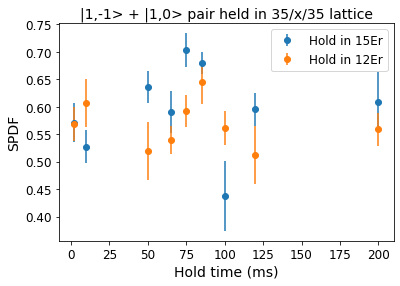

In [141]:
plt.errorbar(np.unique(scan_var), lattice15dat[:, 1, 0], lattice15dat[:, 1, 1], fmt = 'o', label = 'Hold in 15Er')
plt.errorbar(np.unique(scan_var), lattice12dat[:, 1, 0], lattice12dat[:, 1, 1], fmt = 'o', label = 'Hold in 12Er')
plt.xlabel("Hold time (ms)", fontsize = 14)
plt.ylabel("SPDF", fontsize = 14)
plt.legend(fontsize = 12)
plt.title("|1,-1> + |1,0> pair held in 35/x/35 lattice", fontsize = 14)
plt.tick_params(labelsize = 12)